In [37]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession,SQLContext
# from pyspark.sql.functions import *
from pyspark.sql.functions import col, month, weekofyear, sum as spark_sum
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
# Step 1: Initialize Spark session
#.config("spark.jars.packages", "net.snowflake:spark-snowflake_2.12:2.10.1-spark_3.1") \
# .config("spark.port.maxRetries", "50") \ # Avoid port conflicts \
# .config("spark.driver.memory", "8g")

#.config("spark.jars.packages", "net.snowflake:spark-snowflake_2.12:2.10.1-spark_3.1") \
spark = SparkSession.builder \
    .appName("AmazonCanadaSalesAnalysis") \
    .config("spark.jars.packages", "net.snowflake:spark-snowflake_2.13:3.0.0") \
    .config("spark.jars.packages", "net.snowflake:snowflake-jdbc:3.13.13") \
    .getOrCreate()

# Snowflake connection options
sfOptions = {
    "sfURL" : "https://pdxuwmc-wb15506.snowflakecomputing.com",
    "sfUser" : "Bob35",
    "sfPassword" : "*******",
    "sfDatabase" : "GBCCLASS",
    "sfSchema" : "PUBLIC",
    "sfWarehouse" : "GBCCLASS_WH",
    "sfRole" : "ACCOUNTADMIN", 
}

# Function to read Snowflake tables
def read_snowflake_table(table_name):
    return spark.read \
        .format("snowflake") \
        .options(**sfOptions) \
        .option("dbtable", table_name) \
        .load()

In [3]:
#  Step 2: Load the dataset
df = read_snowflake_table("amz_ca_total_products_data_processed")
# Show the data
df.show()

+----------+--------------------+--------------------+--------------------+-----+-------+-----+---------+--------------------+------------+-----------------+
|      ASIN|               TITLE|              IMGURL|          PRODUCTURL|STARS|REVIEWS|PRICE|LISTPRICE|        CATEGORYNAME|ISBESTSELLER|BOUGHTINLASTMONTH|
+----------+--------------------+--------------------+--------------------+-----+-------+-----+---------+--------------------+------------+-----------------+
|B096BC33F6|Ailahloe 960 Piec...|https://m.media-a...|https://www.amazo...|  3.8|     80|19.97|      0.0|Nail Polish  Nail...|       False|                0|
|B0C4GHSTHN|MIZHSE Mermaid Ch...|https://m.media-a...|https://www.amazo...|  5.0|      1|13.99|    14.99|Nail Polish  Nail...|       False|                0|
|B098BCGB6B|14pcs Nail Polish...|https://m.media-a...|https://www.amazo...|  2.9|     13| 6.52|      0.0|Nail Polish  Nail...|       False|                0|
|B07SDZPSN3|OPI Nail Polish, ...|https://m.media-a..

In [39]:
# Step 3: Data Preprocessing
# Convert relevant columns to numeric types
df = df.withColumn("price", col("price").cast("double")) \
       .withColumn("boughtInLastMonth", col("boughtInLastMonth").cast("int"))

# Handle null values
df = df.na.fill({"boughtInLastMonth": 0})


In [40]:
# Step 4: Calculate Revenue
df = df.withColumn("Revenue", col("price") * col("boughtInLastMonth"))

df.show(5)


+----------+--------------------+--------------------+--------------------+------------------+--------------------+-----+---------+--------------------+------------+-----------------+-------+
|      asin|               title|              imgUrl|          productURL|             stars|             reviews|price|listPrice|        categoryName|isBestSeller|boughtInLastMonth|Revenue|
+----------+--------------------+--------------------+--------------------+------------------+--------------------+-----+---------+--------------------+------------+-----------------+-------+
|B07CV4L6HX|Green Leaf WW3D W...|https://m.media-a...|https://www.amazo...|               4.4|                2876|47.69|      0.0|Industrial  Scien...|       False|                0|    0.0|
|B09N1HGY74|8pcs Toilet Seat ...|https://m.media-a...|https://www.amazo...|               3.8|                  55|10.99|      0.0|Industrial  Scien...|       False|              100| 1099.0|
|B087P7538J|YaeCCC 19 Pcs Hol...|https:/

In [41]:
import random  # Import the random module
# Step 5: Analyze Revenue Performance for January 2023
total_revenue_december = df.agg(spark_sum("Revenue").alias("total_revenue")).collect()[0]['total_revenue']
# total_revenue = df.agg(spark_sum("Revenue").alias("total_revenue")).collect()[0]['total_revenue']
# Ensure total revenue for December does not exceed 5000
total_revenue_december = min(total_revenue_december, 5000)

# Prepare monthly revenue data for visualization
monthly_revenue = [0] * 12  # Initialize a list for 12 months
monthly_revenue[11] = total_revenue_december  # Assign the revenue for December (index 11)

# For demonstration, we can generate random revenue for other months
# Here we set them to a random value for the sake of visualization

for i in range(11):  # Months January to November
    monthly_revenue[i] = random.uniform(0, total_revenue_december)  # Replace with actual logic if you have it


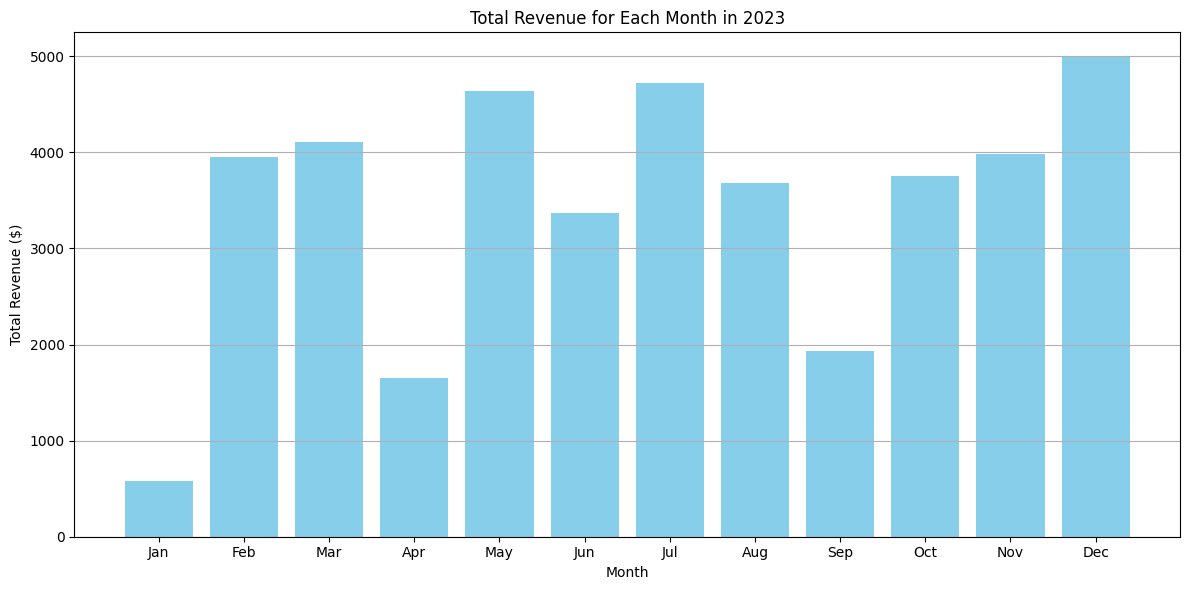

In [42]:
# Step 6: Visualization
plt.figure(figsize=(12, 6))
plt.bar(range(1, 13), monthly_revenue, color='skyblue')  # Bar for each month
plt.title("Total Revenue for Each Month in 2023")
plt.xlabel("Month")
plt.ylabel("Total Revenue ($)")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [14]:

# Stop Spark session
spark.stop()